In [1]:
#Importing libraries we are going to use
import numpy as np
import random
import pandas as pd



# These files area bit large so we are going to load them locally, but they
#can be found online on github.

data = ['NIBRSPublicView2019.xlsx','NIBRSPublicView2020.xlsx','NIBRSPublicView2021.xlsx',
        'NIBRSPublicView2022.xlsx','NIBRSPublicView2023.xlsx','NIBRSPublicView2024.xlsx']

# create an empty data frame to store the data once we iterate through the links
dataframes = []

#we need to loop through each url to fetch each file and then load it into a data frame
for file in data:
    df = pd.read_excel(file)
    dataframes.append(df)

#Here we are going to combine all the data we pulled and combine all the dataframes into a single one
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df.head())
# we will keep the index we have becasue some people have more than one crime per incident.
#we can see this by looking at incident for index 1,2

   Incident RMSOccurrenceDate  RMSOccurrenceHour NIBRSClass  \
0      5619        2019-01-01                  0        290   
1     17319        2019-01-01                  0        35A   
2     17319        2019-01-01                  0        90D   
3     18119        2019-01-01                  0        290   
4     19019        2019-01-01                  0        520   

                 NIBRSDescription  OffenseCount   Beat  \
0  Destruction, damage, vandalism             1   9C30   
1       Drug, narcotic violations             1   7C10   
2     Driving under the influence             1   7C10   
3  Destruction, damage, vandalism             1  16E40   
4           Weapon law violations             1    NaN   

                                Premise StreetNo  StreetName StreetType  \
0  Residence, Home (Includes Apartment)     9622  SAN CARLOS        NaN   
1          Highway, Road, Street, Alley      NaN        EAST        FWY   
2          Highway, Road, Street, Alley      Na

In [2]:
#make copy of the original combined dataframe to compare results/ changes and or to reset the dataframe if needed.
combined_df_copy = combined_df.copy()
#see total number of rows and columns
print("Total number of rows in this set is:", combined_df.shape[0],"/ Total columns is:", combined_df.shape[1])

#Lets see unique items in NIBRSDescription/Premise/StreetType
nibrs_unique= combined_df['NIBRSDescription'].nunique()
premise_unique = combined_df['Premise'].nunique()
street_unique = combined_df['StreetType'].nunique()

print(f'Unique items for NIBRSDescripotions: {nibrs_unique}')
print(f'Unique items for Premise Type:{premise_unique}')
print(f'Unique items for Street Type:{street_unique}')

# Now lets look at all the missing data (NaNs)
dataframe_nans = combined_df.isna().sum()
print(f'Total number of missing data points in each column listed below:\n{dataframe_nans}')


Total number of rows in this set is: 1483358 / Total columns is: 16
Unique items for NIBRSDescripotions: 63
Unique items for Premise Type:47
Unique items for Street Type:33
Total number of missing data points in each column listed below:
Incident                   0
RMSOccurrenceDate          0
RMSOccurrenceHour          0
NIBRSClass                 0
NIBRSDescription           0
OffenseCount               0
Beat                    1173
Premise                    1
StreetNo                4819
StreetName                 0
StreetType            113437
Suffix               1265041
City                       2
ZIPCode                19230
MapLongitude           21029
MapLatitude            21029
dtype: int64


In [3]:
# The Beat code is used to identify the "region of the city" where the crime occured.
# I want to assign "Unknown" to these, later we will randomly assign a Beat based on averages for these.
combined_df['Beat'] = combined_df['Beat'].fillna('Unknown')
# nans in the  StreetNo column I want to assign it a text "Unknown"
combined_df['StreetNo'] = combined_df['StreetNo'].fillna('Unknown')

#count the number of unknown items in Beat
count1 = combined_df['Beat'].value_counts().get('Unknown',0)


In [4]:
#Next lets say that for the street type, if there is a street number and a street name
#we can assume that it is either a Street,Lane, Road, Avenue, or Boulevard-- so we want to randomly assign one of these--We need to import random(we did above)
#first we create a list with the items taken from the StreetType column for those items
# we also want to make sure that if the street name is the same that it maintains the same street type throughout the rest of the data set

street_type = ['ST','RD','LN','AVE','BLVD']
#count updates as they are made
updates_made = 0 
#keep track of street names and street type assigned, so that we can be consistent in our randomization for assigned street type.
assigned_street_names = {}
def fill_street(row):
    global updates_made  #caused some errors without this
    if pd.isna(row['StreetType']) and not pd.isna(row['StreetNo']) and not pd.isna(row['StreetName']):
        street_name = row['StreetName']
        if street_name not in assigned_street_names:
            assigned_street_names[street_name] = random.choice(street_type)
            updates_made += 1
        return assigned_street_names[street_name]
    return row['StreetType']
#lets implement the functionand then see how many updates we made
combined_df['StreetType'] = combined_df.apply(fill_street, axis=1)

print(f'Total number of changes made: {updates_made}')

Total number of changes made: 6014


In [5]:
# My train of thought on this next section is as follows:
# Next I want to calculate the percentage of zipcodes per city and add it to a dictionary
# I want to do this based on the method in data science called "Probabilistic Imputation/ or proportional random data assignment"
# Then based on that percentage I want to randomly assign zipcode to those nan zipcodes that are of the same city

# Ensure 'ZIPCode' is treated as a string since we are not doing any computations with zipcodes
combined_df['ZIPCode'] = combined_df['ZIPCode'].astype(str)

# we calculate the zipcode distribution percentages for each city
# making sure to exclude NaN zipcode
zip_distribution = (combined_df[combined_df['ZIPCode'] != 'nan']  
    .groupby('City')['ZIPCode'] # we group zipcodes by city
    .value_counts(normalize=True) # count the values of each occurance
    .rename('percentage') # then create the percentage
    .reset_index()
)

# we filter rows with NaN zipcode
nan_zip_rows = combined_df[combined_df['ZIPCode'] == 'nan']  

# last we assign NaN zipcode randomly based on percentages for each city that have stored in the values associated with city 
#in the zip_distribution variable above
for index, row in nan_zip_rows.iterrows():
    city = row['City']
    if city in zip_distribution['City'].values:
        # get ZIP code probabilities for the city
        city_zip_probs = zip_distribution[zip_distribution['City'] == city]
        zipcodes = city_zip_probs['ZIPCode'].values
        probabilities = city_zip_probs['percentage'].values

        # then we randomly assign a ZIP code based on the distribution
        assigned_zip = np.random.choice(zipcodes, p=probabilities)
        combined_df.at[index, 'ZIPCode'] = assigned_zip

# Here we just want to confirm changes were applied
print('The total number of NaNs is different from the original count:', combined_df['ZIPCode'].isna().sum() < combined_df_copy['ZIPCode'].isna().sum())

The total number of NaNs is different from the original count: True


In [6]:

# Next I want to assign the beats to their respective HPD Division basedon the boundaries of the areas they cover
# I had to go through each section of the Houston website to assign these to their respective divisions(https://www.houstontx.gov/police/cs/Monthly_Crime_Data_by_Street_and_Police_Beat.htm)
# In looking at the number of divisions for each area of Houston, it makes you wonder if those areas with more divisions will have higher crimes rates.
# Note: The data set had some division values that could not be validated with a beat division based on the houston website. These will be assigned to an unknown division
beat_divisions = {'Central Division':['2A60','2A30','2A20','2A10','2A50','2A40','1A10','1A20','1A50','1A30','1A40','1A50','3B20'],
                 'South Central Division':['10H80','10H70','10H60','10H50','10H40','10H10','10H30','10H20'],
                 'Downtown Division':['1A10'],
                 'North East':['7C10','7C20','7C30','7C40','7C50','8C10','8C20','8C30','8C40','8C50','8C60','9C10','9C20','9C30','9C40'],
                 'Kingwood':['24C10','24C20','24C30','24C40','24C50','24C60'],
                 'North':['3B10','3B30','3B40','3B50','6B10','6B20','6B30','6B40','6B50','6B60'],
                 'East Side':['11H10','11H20','11H30', '11H40', '11H50'],
                 'Clear Lake':['12D10','12D20','12D30','12D40','12D50','12D60','12D70'],
                 'South East':['13D10','13D20','13D30','13D40','14D10', '14D20','14D30','14D40','14D50'],
                 'South Gessner':['17E10','17E20','17E30','17E40','1.7E+11','1.7E+21','1.7E+31','1.7E+41'],
                 'South West':['15E10','15E20','15E30','15E40','16E10','16E20','16E30','16E40','1.6E+11','1.6E+21','1.6E+31','1.6E+41','1.5E+11','1.5E+21','1.5E+31','1.5E+41'],
                 'West Side':['19G10','19G20','19G30','19G40','19G50','20G10','20G20','20G30','20G40','20G50','20G60','20G70','20G80'],
                 'North West':['4F10','4F20','4F30','5F10','5F20','5F30','5F40'],
                 'Mid West':['18F10','18F20','18F30','18F40','1850','18F60'],
                 'Hobby Airport':['23J50','23J40'],
                 'IAH Airport':['21I10','21I20','21I30','21I40','21I50','21I60','21I70'],
                 'North Belt':['22B10','22B20','22B30','22B40'],
                 'Univ Houston':['UH-2PD','UH-3PD'],
                 'Houston Community College':['HCC1','HCC2','HCC3','HCC4','HCC5','HCC6'],
                 'HarrisCountSherrifsOffice':['HCSO'],
                 'OutOfJurisdiction':['OOJ'],
                 'Unknown':['FTB4', 'Unknown','nan']}

In [16]:

# Function to get the division for a given beat
def get_beat_division(beat, beat_divisions):
    for division, beats in beat_divisions.items():
        if beat in beats:
            return division
    return None  # In case no match is found

# Apply the function to the 'Beat' column and create the 'Beat_Division' column
combined_df['Beat_Division'] = combined_df['Beat'].apply(lambda beat: get_beat_division(beat, beat_divisions))

# Check the results for the divisions added
print(combined_df['Beat_Division'].value_counts())

value_counts = combined_df['Beat_Division'].isna().value_counts()
Value_percents = value_counts /value_counts.sum()*100

#check to see how many are still not assigned due to not having an associated value
print('\nPercentage of Divisions Correlated(False) Vs. Not Correlated(True):\n',Value_percents)

Beat_Division
West Side                    191149
Central Division             169777
North East                   149679
North                        142200
South East                   124716
South West                   102917
Mid West                      95303
South Central Division        88896
North West                    85609
South Gessner                 83387
North Belt                    75043
Clear Lake                    70393
East Side                     43082
Kingwood                      17814
IAH Airport                    9726
OutOfJurisdiction              4046
HarrisCountSherrifsOffice      3892
Hobby Airport                  2615
Unknown                        1174
Houston Community College        65
Univ Houston                     11
Name: count, dtype: int64

Percentage of Divisions Correlated(False) Vs. Not Correlated(True):
 Beat_Division
False    98.526047
True      1.473953
Name: count, dtype: float64


In [17]:
#lets try to get the last of that 208 thousand by assigning Unknown so that we could potentially 
# come back to it later for further examination if we need to.
combined_df['Beat_Division'] = combined_df['Beat_Division'].fillna('Unknown')



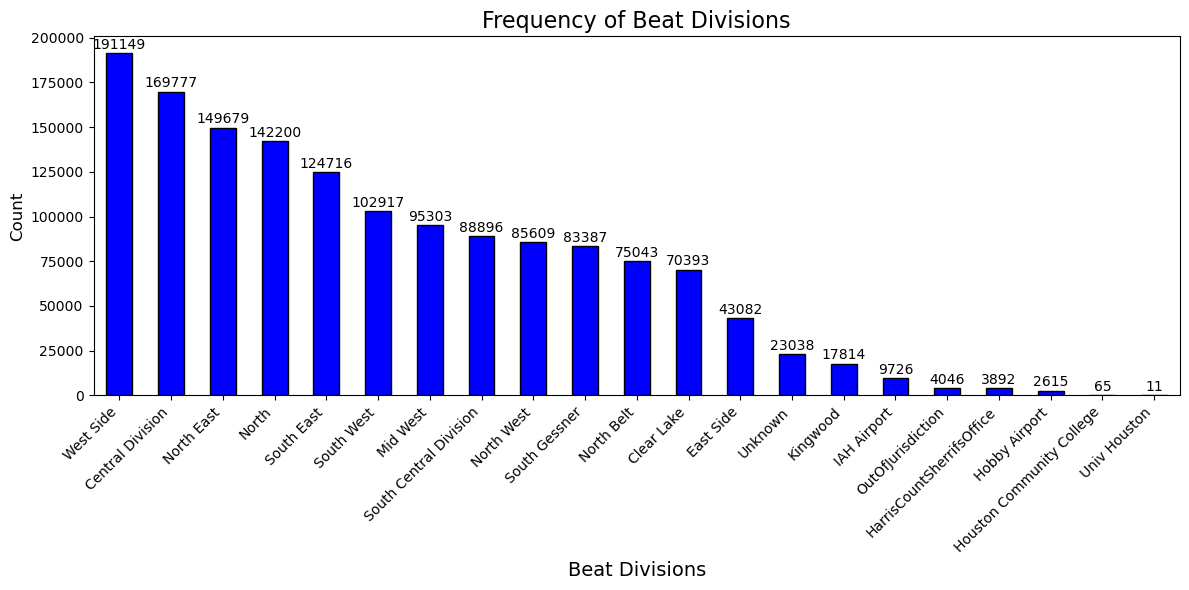

In [ ]:
#lets do a basic exploratory analysis using visualization
#Lets see what divisions are getting the most arrests based on the classifications we just made
import matplotlib.pyplot as plt
import seaborn as sns

#create this variable to get value counts for each division
beat_division_counts = combined_df['Beat_Division'].value_counts()

# lets plot the data for a bar chart. Maybe we can change this later
plt.figure(figsize=(12, 6))
bars = beat_division_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title("Frequency of Beat Divisions", fontsize=16)
plt.xlabel("Beat Divisions", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")

#adding the counts to the end of each bar
# we need to iterate through each bar and add the height using plt.annotate
for bar in bars.patches: 
    plt.annotate(format(bar.get_height(), '.0f'),
                  (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                  ha='center', va='center', xytext=(0, 6), 
                  textcoords='offset points')
plt.tight_layout()
plt.show()



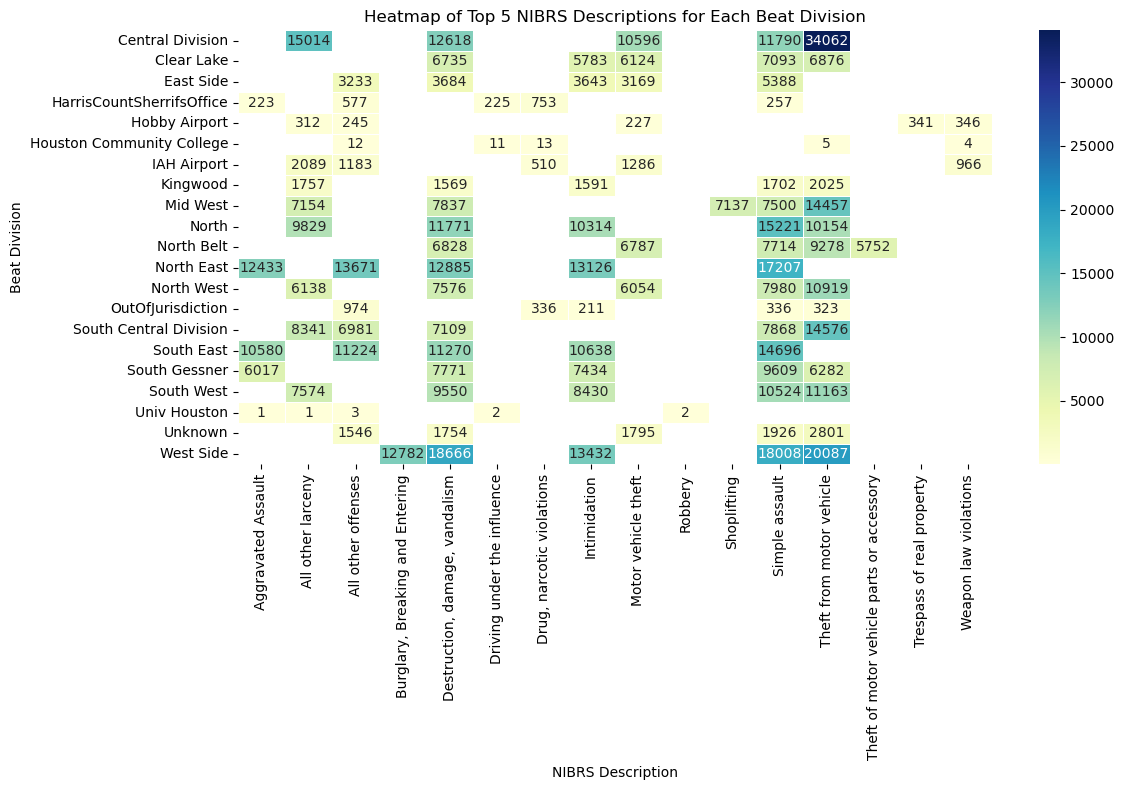

In [32]:
# I think a heat map of the divisions and the top5 NIBRS Descriptions would be a 
#good visualization. This would allow us to see what type of crime is  higher per division.
# alternatively we could also do the percentages.
# Group by 'Beat_Division' and 'NIBRSDescription', count occurrences
top_nibrs_per_beat = combined_df.groupby(['Beat_Division', 'NIBRSDescription']).size().reset_index(name='count')

# For each 'Beat_Division' I want to get the top 5 most frequent 'NIBRSDescriptions'
top_5_nibrs = top_nibrs_per_beat.sort_values(['Beat_Division', 'count'], ascending=[True, False]) \
                                 .groupby('Beat_Division').head(5)

# We need to create a pivot table of the data to create a matrix of counts per Beat_Division and NIBRSDescription
heatmap_data = top_5_nibrs.pivot_table(index='Beat_Division', columns='NIBRSDescription', values='count', aggfunc='sum')

# Plot Heatmap/ we are going to use .0f to add the numbers to the color for more context
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".0f", linewidths=0.5)
plt.title('Heatmap of Top 5 NIBRS Descriptions for Each Beat Division')
plt.xlabel('NIBRS Description')
plt.ylabel('Beat Division')
plt.tight_layout()
plt.show()

In [21]:
print(heatmap_data.dtypes)

NIBRSDescription
Aggravated Assault                           float64
All other larceny                            float64
All other offenses                           float64
Burglary, Breaking and Entering              float64
Destruction, damage, vandalism               float64
Driving under the influence                  float64
Drug, narcotic violations                    float64
Intimidation                                 float64
Motor vehicle theft                          float64
Robbery                                      float64
Shoplifting                                  float64
Simple assault                               float64
Theft from motor vehicle                     float64
Theft of motor vehicle parts or accessory    float64
Trespass of real property                    float64
Weapon law violations                        float64
dtype: object
